# Exploratory analysis of univariate and compound events

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:10:00'
cores = 4
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46505 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.74.69:46505/status,
Dashboard: http://10.6.74.69:46505/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.74.69:45073,Workers: 0
Dashboard: http://10.6.74.69:46505/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [6]:
# %load_ext autoreload
# %autoreload 2

In [7]:
# %reload_ext autoreload
# %autoreload 2

In [8]:
import warnings

import xarray as xr
import numpy as np
import geopandas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [9]:
import functions as fn

season_dict = fn.get_seasons()

plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load REZ and city shapefiles

In [10]:
rez_file = '/g/data/w42/dr6273/work/data/REZ_boundaries_2021/Indicative_REZ_boundaries_2021_-_GIS_data-polygon.shp'
rez_gpd = geopandas.read_file(rez_file)

Add central coords of REZ regions

In [11]:
rez_gpd['coords'] = rez_gpd['geometry'].apply(lambda x: x.representative_point().coords[:])
rez_gpd['coords'] = [coords[0] for coords in rez_gpd['coords']]

Add column of energy type codes

In [12]:
region_codes = [
    3, 7, 3, 3, 2, 2, 4, 4,     # NSW
    1, 1, 1, 1,                 # Offshore wind
    5, 7, 6, 7, 3, 7, 6, 3, 7,  # QLD
    1, 3, 1, 1, 4, 3, 2, 3, 3,  # SA
    3, 7, 7,                    # TAS
    6, 3, 1, 1, 3, 2            # VIC
]

In [13]:
rez_gpd['energy_code'] = 0

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rez_gpd['energy_code'].iloc[9:17] = region_codes[:8]
    rez_gpd['energy_code'].iloc[[33, 34, 37, 38]] = region_codes[8:12]
    rez_gpd['energy_code'].iloc[:9] = region_codes[12:21]
    rez_gpd['energy_code'].iloc[23:32] = region_codes[21:30]
    rez_gpd['energy_code'].iloc[[32, 35, 36]] = region_codes[30:33]
    rez_gpd['energy_code'].iloc[17:23] = region_codes[33:]

In [15]:
gccsa_file = '/g/data/w42/dr6273/work/data/ABS_GCCSA_2021/GCCSA_2021_AUST_GDA2020.shp'
gccsa_gpd = geopandas.read_file(gccsa_file)

In [16]:
gccsa_gpd = gccsa_gpd.loc[
    (gccsa_gpd['GCC_NAME21'] == 'Greater Sydney') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Melbourne') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Brisbane') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Adelaide') |
    (gccsa_gpd['GCC_NAME21'] == 'Australian Capital Territory') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Hobart')
]

In [52]:
def plot_REZ_GCCSA(ax):
    """
    Plot REZ and GCCSA shape files with labels.
    """
    ax.set_extent([132, 160.01, -9, -46])
    ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.2,
        rasterized=True
    )
    ax.coastlines(resolution="50m", lw=0.5, rasterized=True)
    
    ax.set_xticks(np.arange(135, 161, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-10, -46, -5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    alpha=0.6
    for i in range(len(rez_gpd)):
        d = rez_gpd.iloc[i:i+1]
        code = d.iloc[0]['energy_code']
        if (code == 1) | (code == 5):
            d.plot(ax=ax, alpha=alpha, color=colors[0], label='Wind', rasterized=True)
        elif (code == 2) | (code == 6):
            d.plot(ax=ax, alpha=alpha, color=colors[1], label='Solar', rasterized=True)
        elif (code == 3) | (code == 7):
            d.plot(ax=ax, alpha=alpha, color=colors[4], label='Wind and solar', rasterized=True)
        elif code == 4:
            pass
        else:
            raise ValueError('Incorrect code')
                        
    for idx, row in rez_gpd.iterrows():
        code = row['energy_code']
        label = row['Name'][:2]
        
        if label in ['O1', 'O2', 'Q1', 'Q3', 'Q6']:
            x = row.coords[0] + 1
            y = row.coords[1]
        elif label == 'O3':
            x = row.coords[0] + 1
            y = row.coords[1] - 0.5
        elif label == 'O4':
            x = row.coords[0]
            y = row.coords[1] + 0.5
        else:
            x = row.coords[0]
            y = row.coords[1]
            
        # if code != 4:
        #     ax.text(
        #         x,
        #         y,
        #         s=label,
        #         horizontalalignment='center',
        #         bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 0.5, 'edgecolor':'none'}
        #     )

    gccsa_gpd.plot(ax=ax, edgecolor=colors[3], facecolor=colors[3], alpha=alpha, rasterized=True)
    
    ax.text(138.5, -25.5, 'Queensland (QLD)')
    ax.text(141.5, -31, 'New South\nWales (NSW)')
    ax.text(132.5, -28.5, 'South\nAustralia (SA)')
    ax.text(134.5, -40.5, 'Victoria (VIC)')
    ax.text(138, -44.5, 'Tasmania (TAS)')
    ax.text(153, -38, 'Offshore')
    
    ax.text(154, -28, 'Brisbane')
    ax.text(154, -34, 'Sydney')
    ax.text(136.5, -42, 'Melbourne')
    ax.text(134.5, -38, 'Adelaide')
    ax.text(153, -36, 'Canberra')
    ax.text(148, -44, 'Hobart')
    
    ax.plot((151.7, 153.5), (-33.7, -33.7), c=colors[3]) # SYD
    ax.plot((142.2, 144.5), (-40.9, -38.5), c=colors[3]) # MLB
    ax.plot((141., 142), (-39.3, -38.5), c='k') # VIC
    ax.plot((138.5, 138.5), (-37, -36), c=colors[3]) # ADL
    ax.plot((149.5, 152.5), (-35.7, -35.7), c=colors[3]) # CBR
    
    # Offshore lines
    ax.plot((152.5, 152), (-37.7, -33.8), c=colors[0], ls='--')
    ax.plot((152.5, 151.4), (-37.7, -35), c=colors[0], ls='--')
    ax.plot((152.5, 148.2), (-37.7, -38.5), c=colors[0], ls='--')
    ax.plot((152.5, 145.9), (-37.7, -40.5), c=colors[0], ls='--')
    
    # Custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Solar',
                markerfacecolor=colors[1], markersize=12, alpha=alpha),
        Line2D([0], [0], marker='o', color='w', label='Wind',
                markerfacecolor=colors[0], markersize=12, alpha=alpha),
        Line2D([0], [0], marker='o', color='w', label='Solar and wind',
                markerfacecolor=colors[4], markersize=12, alpha=alpha)
    ]
    ax.legend(
        frameon=False,
        handles=legend_elements,
        loc=(0.55, 0.78),
        fontsize=plt_params['font.size'],
        labelspacing=.8
    )
    ax.set_title('(a) Renewable energy zones (REZs)\nand major cities')

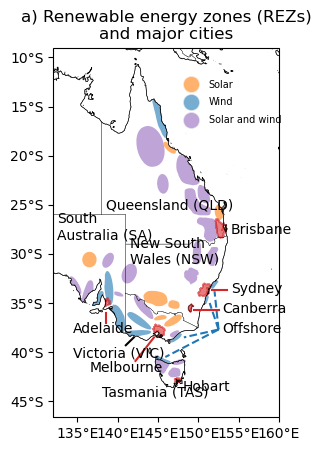

In [54]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
plot_REZ_GCCSA(ax)

# Load masks

In [18]:
rez_mask = fn.get_rez_mask()

In [19]:
gccsa_mask = fn.get_gccsa_mask()

# Load energy source and demand data

### REZ regions

In [20]:
years = range(1959, 2022)

Sources: daily wind, daily solar and monthly runoff

In [21]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w'].compute()

In [22]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd'].compute()

In [23]:
rez_ro = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/ro_era5_monthly-averaged_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['ro'].compute()

Demand: daily temperature

In [24]:
# city_t = xr.open_zarr(
#     '/g/data/w42/dr6273/work/projects/Aus_energy/data/t2m_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_GCCSA_region_mean.zarr',
#     consolidated=True
# )['t2m'].compute()

# # Convert to Celsius
# city_t = city_t - 273.15

### Aus - gridded

In [25]:
aus_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_1959-2021_AUS_region.zarr',
    consolidated=True
)['w100']

In [26]:
aus_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_1959-2021_AUS_region.zarr',
    consolidated=True
)['msdwswrf']

# How often to regional means exceed operational thresholds?

- For wind, we use 4 m/s (operating cut-in speed from Ridder report and elsewhere). Ridder also uses 5th percentile, which is 3.6 in NSW, but we calculate that as 2.8 (NSW) or 2.5 (all states).

- For solar, use 170 W/m^2 (Prasad 2021). Note however that this value was obtained as the 25th percentile of all values in Australia in their study. The 25th percentile over all REZs is lower: 132 W/m^2. Or we could use 95 W/m^2 (calculated from 342 kJ/hr in Ridder report using https://www.unitconverters.net/power/kilojoule-hour-to-watt.htm). But, that value is calculated as 5th percentile in NSW. We get 74 W/m^2 for NSW, 70 for all states.
- For hydro, use 20th percentile of annual total runoff by region (made up)

- For temperature demand, we use a lower limit of 15 C and an upper limit of 21 C. From here: https://www.energyrating.gov.au/sites/default/files/documents/Climate_zone_mapping_-_air_con_FINAL_title_updated_0.pdf ### Note this link is broken. Could use 16 and 21 from here: https://www.iea.org/articles/australia-climate-resilience-policy-indicator

In [27]:
def freq_drought_compare(daily_events,
                         ann_da, thresh_ann_da,
                         tail='lower', time_name='time'):
    """
    Calculate frequency of daily events (i.e. days surpassing some threshold)
    on drought years (years below some threshold), and
    on all other years. Output is two dataarrays.
    
    daily_da: xarray dataarray of daily data
    thresh_daily_da: int, float or da. Threshold to define daily events.
    drought_da: xarray dataarray of annual data (typically runoff or precip)
    thresh_drought_da: int, float or da. Threshold to define drought events.
    tail: string, 'lower' (default) or 'upper'. Whether daily events are
        defined as below or above the threshold.
    """                            
    def freq_during_years(da, years, time_name):
        """
        Frequency of events on given years.
        """
        subset_da = da.sel(
            time=da[time_name].dt.year.isin(years)
        )
        counts = subset_da.sum(time_name)

        return counts / len(subset_da[time_name].values)

    # We need to do it separately for each region because different times
    #  may be dropped (different drought years across regions).
    drought_da_list = []
    other_da_list = []
    for i, region in enumerate(daily_events.region.values):
        # Get drought and other years
        drought_years, other_years = fn.get_event_years(
            ann_da.sel(region=region),
            thresh_ann_da, #.sel(region=region),
            tail,
            time_name
        )
        
        # Frequency during drought and other years
        r_events = daily_events.sel(region=region)
        
        freq_during_drought = freq_during_years(r_events,
                                                drought_years,
                                                time_name)
        freq_during_other = freq_during_years(r_events,
                                              other_years,
                                              time_name)
        
        drought_da_list.append(freq_during_drought)
        other_da_list.append(freq_during_other)
        
    drought_da = xr.concat(drought_da_list, dim='region')
    other_da = xr.concat(other_da_list, dim='region')
    
    return drought_da, other_da

In [48]:
def plot_freq(ax, da, title, mask, region_codes=None, vmin_vmax_interval='auto'):
    """
    Plot relative frequencies of events.
    """
    regions = da.region
    if isinstance(region_codes, list):
        regions = fn.get_regions_from_region_codes(region_codes, rez_mask)
    da = xr.where(mask.sel(region=regions),
                  da.sel(region=regions),
                  np.nan)
    da = da.sum('region', skipna=True)
    plot_da = da.where(mask.sel(region=regions).sum('region'))
    
    # Get data and colorbar limits
    if vmin_vmax_interval == 'auto':
        da_max = plot_da.max().values
        da_min = plot_da.min().values
        
        if da_min >= 0: # For positive data, this will lie 0-1
            cmap = 'RdBu_r'
            norm = matplotlib.colors.CenteredNorm(vcenter=0.25 ** 2)
            vmin = 0
            if da_max > 0.2:
                vmax = 0.5 * 100 #fn.round_decimals_up(da_max, 1)
                cbar_tick_intervals = 0.1 * 100
            elif da_max > 0.1:
                vmax = 0.25 ** 2 * 2 * 100 #fn.round_decimals_up(da_max, 2)
                cbar_tick_intervals = 0.02 * 100
            else:
                vmax = fn.round_decimals_up(da_max, 3) * 100
                cbar_tick_intervals = 0.001 * 100
        else: # Symmetric data
            cmap = 'RdBu_r'
            norm = None
            abs_max = np.max([np.abs(da_min), da_max])
            if abs_max > 0.2:
                vmax = fn.round_decimals_up(abs_max, 1) * 100
                cbar_tick_intervals = 0.1 * 100
            elif abs_max > 0.1:
                vmax = fn.round_decimals_up(abs_max, 1) * 100
                cbar_tick_intervals = 0.02 * 100
            else:
                vmax = fn.round_decimals_up(abs_max, 2) * 100
                cbar_tick_intervals = 0.01 * 100
            vmin = -vmax
                
    elif isinstance(vmin_vmax_interval, list):
        cmap = 'viridis'
        vmin = vmin_vmax_interval[0] * 100
        vmax = vmin_vmax_interval[1] * 100
        cbar_tick_intervals = vmin_vmax_interval[2] * 100
    else:
        raise ValueError("vmin_vmax_interval should be 'auto' or list with the \
        first element the desired vmin, and the second element vmax.")
                
    with plt.rc_context(plt_params):
        # ax.coastlines()
        ax.add_feature(
            cartopy.feature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces',
                                                scale='10m'),
            facecolor='none', edgecolor='k', lw=0.1,
            rasterized=True
        )
        ax.coastlines(lw=0.3, rasterized=True)

        p = (plot_da * 100).plot(ax=ax, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
        
        # Colorbar
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        axins = inset_axes(ax, width="10%", height="100%",
                           bbox_to_anchor=(1.03, .01, .5, .99),
                           bbox_transform=ax.transAxes, loc='lower left', borderpad=0)
        cb1 = matplotlib.colorbar.ColorbarBase(ax=axins, cmap=cmap, norm=norm,
                                               ticks=np.arange(vmin, vmax+cbar_tick_intervals, cbar_tick_intervals),
                                               orientation='vertical')
        ax.set_title(title)

In [29]:
rez_ro_ann = rez_ro.resample(time='1YS').sum()

In [30]:
thresh_100w = rez_100w.quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7
# thresh_ro = rez_ro_ann.quantile(0.25, ['time'])
thresh_t_cool = 15
thresh_t_warm = 21

# Or, runoff threshold is 25th percentile of the average annual runoff across all regions that have hydro
thresh_ro = rez_ro_ann.sel(
    region=fn.get_regions_from_region_codes([4, 5, 6, 7], rez_mask)
).mean('region').quantile(0.25, 'time')

### Frequencies of univariate events

In [31]:
freq_100w = fn.calculate_event_frequency(rez_100w, thresh_100w, tail='lower')

In [32]:
freq_mssrd = fn.calculate_event_frequency(rez_mssrd, thresh_mssrd, tail='lower')

In [33]:
freq_ro = fn.calculate_event_frequency(rez_ro_ann, thresh_ro, tail='lower')

In [34]:
# freq_t_upp = fn.calculate_event_frequency(city_t, thresh_t_warm, tail='upper')

In [35]:
# freq_t_low = fn.calculate_event_frequency(city_t, thresh_t_cool, tail='lower')

### Frequencies of compound wind and solar lulls

In [36]:
freq_100w_mssrd = fn.calculate_compound_frequency(
    rez_100w, rez_mssrd, thresh_100w, thresh_mssrd)

### Solar and/or wind lulls compounding with hydropower droughts

We show the difference in relative frequency between wind/solar/compound lulls on drought years and all other years (drought - other).

Only REZs with hydro are shown, because the drought years are specific to each REZ.

Wind during drought

In [37]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower')

freq_drought_100w, freq_other_100w = freq_drought_compare(
    events_100w, rez_ro_ann, thresh_ro, tail='lower'
)

Solar during drought

In [38]:
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower')

freq_drought_mssrd, freq_other_mssrd = freq_drought_compare(
    events_mssrd, rez_ro_ann, thresh_ro, tail='lower'
)

Wind and solar during drought

In [39]:
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd)

freq_drought_100w_mssrd, freq_other_100w_mssrd = freq_drought_compare(
    events_100w_mssrd, rez_ro_ann, thresh_ro, tail='lower'
)

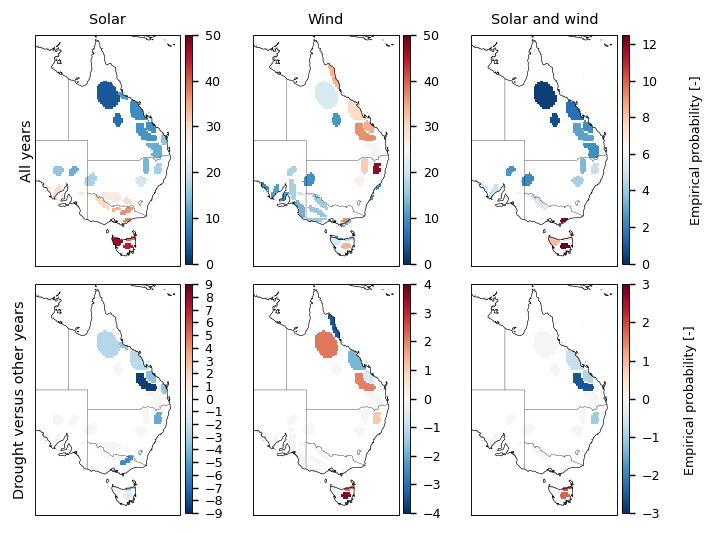

In [49]:
with plt.rc_context(plt_params):
    fig = plt.figure(1, dpi=130)

    ax1 = plt.subplot(231, projection=ccrs.PlateCarree())
    ax2 = plt.subplot(232, projection=ccrs.PlateCarree())
    ax3 = plt.subplot(233, projection=ccrs.PlateCarree())
    ax4 = plt.subplot(234, projection=ccrs.PlateCarree())
    ax5 = plt.subplot(235, projection=ccrs.PlateCarree())
    ax6 = plt.subplot(236, projection=ccrs.PlateCarree())
    
    plot_freq(ax1, freq_mssrd, 'Solar', mask=rez_mask, region_codes=[2, 3, 6, 7])
    plot_freq(ax2, freq_100w, 'Wind', mask=rez_mask, region_codes=[1, 3, 5, 7])
    plot_freq(ax3, freq_100w_mssrd, 'Solar and wind', mask=rez_mask, region_codes=[3, 7])
    plot_freq(ax4, freq_drought_mssrd - freq_other_mssrd,
              '', mask=rez_mask, region_codes=[2, 3, 6, 7])
    plot_freq(ax5, freq_drought_100w - freq_other_100w,
              '', mask=rez_mask, region_codes=[1, 3, 5, 7])
    plot_freq(ax6, freq_drought_100w_mssrd - freq_other_100w_mssrd,
              '', mask=rez_mask, region_codes=[3, 7])
    
    ax1.text(-0.1, 0.5, 'All years', rotation=90, fontsize=plt_params['axes.titlesize'],
             transform=ax1.transAxes, va='center', ha='left')
    ax4.text(-0.1, 0.5, 'Drought versus other years', rotation=90, fontsize=plt_params['axes.titlesize'],
             transform=ax4.transAxes, va='center', ha='center')
    
    ax3.text(1.5, 0.5, 'Empirical probability [-]', rotation=90, fontsize=plt_params['font.size'],
             transform=ax3.transAxes, va='center', ha='left')
    ax6.text(1.5, 0.5, 'Empirical probability [-]', rotation=90, fontsize=plt_params['font.size'],
             transform=ax6.transAxes, va='center', ha='center')
    
    plt.subplots_adjust(hspace=0.08, wspace=0.05)

# Plot correlation of wind and solar? Freq of wind and solar droughts per year?

Correlation between annual means of wind speed and solar.

In [124]:
aus_100w_annual = aus_100w.resample(time='1YS').mean()#.compute()

In [125]:
aus_mssrd_annual = aus_mssrd.resample(time='1YS').mean()#.compute()

In [126]:
cor_annual = xr.corr(aus_100w_annual, aus_mssrd_annual, dim='time').compute()

Correlation between annual frequencies of wind and solar droughts. Droughts defined using temporal and REZ-region average. Maybe at some point should compare with an all-Aus region average.

In [127]:
aus_events_100w = fn.get_events(aus_100w, thresh_100w, tail='lower')
aus_events_100w_annual = aus_events_100w.resample(time='1YS').mean() #.compute()

In [128]:
aus_events_mssrd = fn.get_events(aus_mssrd, thresh_mssrd, tail='lower')
aus_events_mssrd_annual = aus_events_mssrd.resample(time='1YS').mean()#.compute()

In [129]:
cor_events_annual = xr.corr(aus_events_100w_annual, aus_events_mssrd_annual, dim='time').compute()

Plot

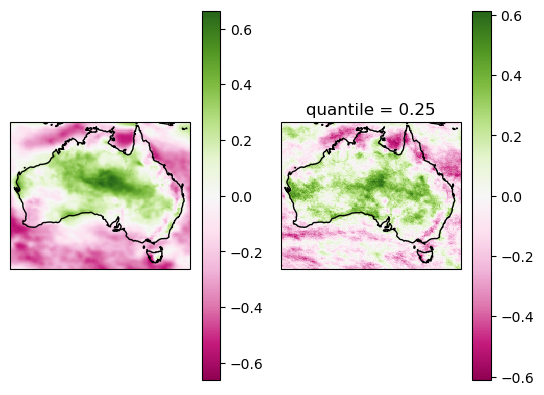

In [139]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

ax[0].coastlines()
ax[1].coastlines()

cor_annual.plot(ax=ax[0], cmap='PiYG', add_colorbar=True)
p = cor_events_annual.plot(ax=ax[1], cmap='PiYG', add_colorbar=True)

### Seasonally

In [120]:
aus_100w_winter = aus_100w.isel(time=aus_100w.time.dt.month.isin([12, 1, 2])).resample(time='1YS').mean()

In [121]:
aus_mssrd_winter = aus_mssrd.isel(time=aus_mssrd.time.dt.month.isin([12, 1, 2])).resample(time='1YS').mean()

In [122]:
cor_winter = xr.corr(aus_100w_winter, aus_mssrd_winter, dim='time').compute()

Task exception was never retrieved
future: <Task finished name='Task-574799' coro=<Client._gather.<locals>.wait() done, defined at /g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit


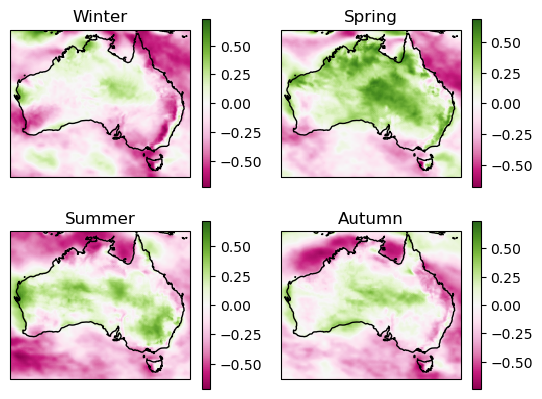

In [143]:
fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})

for i, (season, months) in enumerate(zip(list(season_dict.keys())[1:], list(season_dict.values())[1:])):
    
    a = aus_100w.isel(time=aus_100w.time.dt.month.isin([months])).resample(time='1YS').mean()
    b = aus_mssrd.isel(time=aus_mssrd.time.dt.month.isin([months])).resample(time='1YS').mean()
    cor = xr.corr(a, b, dim='time').compute()

    axis = ax.flatten()[i]
    axis.coastlines()
    cor.plot(ax=axis, cmap='PiYG')
    axis.set_title(season)

# How often do these lulls occur simultaneously across regions?

### Daily events by region

In [64]:
def to_dayofyear(ds):
    """
    Reshapes array from time to year and dayofyear. Leap year days are
    removed, and days after this are reassigned as if there was no leap year.
    So dayofyear is always 1-365.
    
    From: https://github.com/pydata/xarray/discussions/5119#discussioncomment-581232
    """
    
    ds = ds.convert_calendar('noleap')
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(
        year=("time", year.data),
        dayofyear=("time", day.data)
    )

    # reshape the array to (..., "dayofyear", "year")
    return ds.set_index(
        time=("year", "dayofyear")
    ).unstack("time") 

In [65]:
w100_2d = to_dayofyear(events_100w)
mssrd_2d = to_dayofyear(events_mssrd)

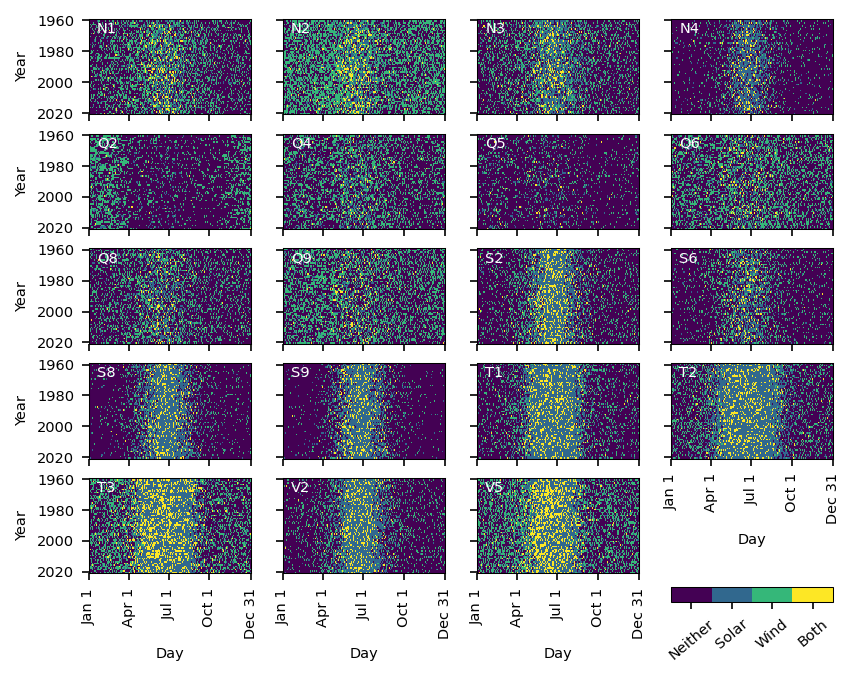

In [150]:
regions = fn.get_regions_from_region_codes([3, 7], rez_mask)
d = mssrd_2d + w100_2d * 2

cmap = matplotlib.cm.get_cmap('viridis')
cmapBig = matplotlib.cm.get_cmap('viridis', 512)
cmap_max = 512
cbar_max = 4.5
newcmap = matplotlib.colors.ListedColormap(cmapBig(np.linspace(0, 1, cmap_max//2)))
norm = matplotlib.colors.BoundaryNorm(np.arange(cbar_max + 0.5), newcmap.N)

with plt.rc_context(plt_params):
    fig, ax = plt.subplots(5, 4, dpi=150)
    
    for i, region in enumerate(regions):
        # d.sel(region=region).plot(ax=ax.flatten()[i],
        #                           add_colorbar=False)
        p = ax.flatten()[i].pcolormesh(
            d.sel(region=region).data,
            cmap=cmap, norm=norm
        )
        ax.flatten()[i].set_ylim(ax.flatten()[i].get_ylim()[::-1])
        
        ax.flatten()[i].set_title('')
        ax.flatten()[i].text(0.05, 0.85, region,
                             c='w', transform=ax.flatten()[i].transAxes)
        
        if i in [0, 4, 8, 12, 16]:
            ax.flatten()[i].set_ylabel('Year')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels(range(1960, 2021, 20))
        else:
            ax.flatten()[i].set_ylabel('')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels('')
            
        if i > 14:
            ax.flatten()[i].set_xlabel('Day')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels(['Jan 1', 'Apr 1', 'Jul 1', 'Oct 1', 'Dec 31'],
                                           rotation=90)
        else:
            ax.flatten()[i].set_xlabel('')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels('')
            
    ax.flatten()[-1].axis('off')
    
    axins1 = inset_axes(ax.flatten()[-1], width="200%", height="20%",
                        bbox_to_anchor=(.5, -0.3, .5, .8),
                        bbox_transform=ax.flatten()[-1].transAxes, loc='lower right', borderpad=0)
    cb1 = fig.colorbar(p, cax=axins1, orientation='horizontal', ticks=np.arange(0.5, cbar_max, 1))
    cb1.ax.minorticks_off()
    cb1.ax.set_xticklabels(['Neither', 'Solar', 'Wind', 'Both'], rotation=40)

### Daily events over all regions

In [40]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

In [41]:
simul_100w_CE = fn.concurrent_univariate_or_compound_lulls(
    events_100w_mssrd, events_100w, [1, 3, 5, 7], rez_mask)

In [42]:
simul_mssrd_CE = fn.concurrent_univariate_or_compound_lulls(
    events_100w_mssrd, events_mssrd, [2, 3, 6, 7], rez_mask)

In [43]:
all_events_no_compound = fn.get_all_events(events_100w, events_mssrd, False)
all_events = fn.get_all_events(events_100w, events_mssrd, True)

In [44]:
def hist_plot(ax, da, months, color, label,
              fill_alpha=0.3, xlim=39, time_name='time', zorder=0):
    """
    Plot histogram.
    """
    subset_da = fn.month_subset(da, months, time_name)
    b = np.linspace(0, subset_da.max().values, subset_da.max().values + 1)
    bins, hist = fn.hist_data(subset_da, b)
    
    ax.plot(bins, hist, color=color, label=label, zorder=zorder)
    ax.fill_between(bins, 0, hist, color=color, alpha=fill_alpha, zorder=zorder)
    
    ymax = fn.round_decimals_up(hist.max().values, 1)
    ax.set_ylim(0, ymax)
    ax.set_yticks(np.arange(0, ymax+0.01, 0.2))
    
    ax.set_xlim(0, xlim+0.5)
    ax.set_xticks(np.arange(0, xlim+0.5, 5))
    
    return hist

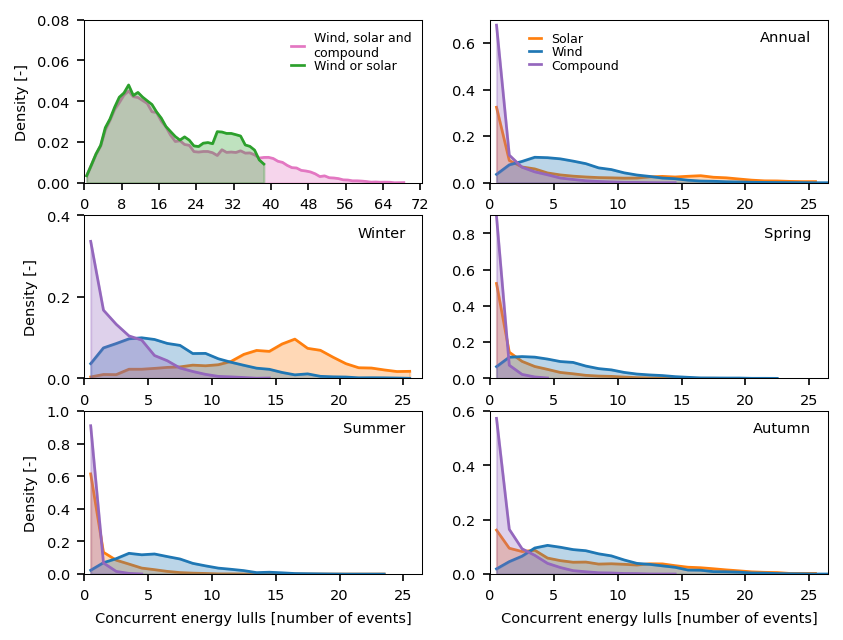

In [48]:
with plt.rc_context(plt_params):
    fig = plt.figure(1, dpi=150)
    
    # Wind and solar events together, with and without double counting of compound events
    # ========================================
    ax = fig.add_subplot(321)
    hist_plot(ax, all_events, season_dict['Annual'], colors[6], 'Wind, solar and\ncompound', xlim=72)
    hist_plot(ax, all_events_no_compound, season_dict['Annual'], colors[2], 'Wind or solar', xlim=72)
    ax.set_xticks(np.arange(0, 73, 8))
    ax.set_ylim(0, 0.08)
    ax.set_yticks(np.arange(0, 0.09, 0.02))
    # ax.set_xlabel('Concurrent energy lulls [number of events]')
    
    ax.legend(frameon=False)
    ax.set_ylabel('Density [-]')
    
    # Wind solar and compound events by season
    # ========================================
    axes = [fig.add_subplot(321 + i) for i in [1, 2, 3, 4, 5]]
    
    for (ax, months, title) in zip(axes, season_dict.values(), season_dict.keys()):
    
        p1 = hist_plot(ax, simul_mssrd, months, colors[1], 'Solar')
        p2 = hist_plot(ax, simul_100w, months, colors[0], 'Wind')
        p3 = hist_plot(ax, simul_100w_mssrd, months, colors[4], 'Compound')
        
        ymax = np.max([p1.max(), p2.max(), p3.max()])
        ax.set_ylim(0, fn.round_decimals_up(ymax, 1))
        ax.text(0.95, 0.85, title, transform=ax.transAxes, ha='right', va='bottom')
        
        ax.set_xlim(0, 26.5)
        ax.set_xticks(np.arange(0, 27, 5))
        # ax.set_xticklabels(np.arange(0, 27, 5))
        
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc=(0.1, 0.65), frameon=False)
    
    for ax in [axes[i] for i in [1, 3]]:
        ax.set_ylabel('Density [-]')
    for ax in [axes[i] for i in [3, 4]]:
        ax.set_xlabel('Concurrent energy lulls [number of events]')
        
    # plt.subplots_adjust(hspace=0.5)

## Note on above plot

Number/probability of zero compound lulls across all regions is higher than number of solar or wind, or solar+wind lulls, because lulls can occur in different regions. A day might have one region with a wind lull, and 10 with solar lulls. If these regions are not overlapping, there is zero compound lulls.

In winter, there are no days for which no regions have solar lulls, and ~3% days with no regions having wind lulls. There is ~11% days with no regions having compound lulls. So some of these 11% days will have >0 regions with wind lulls. (But none of those days will have >0 regions with solar lulls, because we can see this is zero.)

# Combine various plots

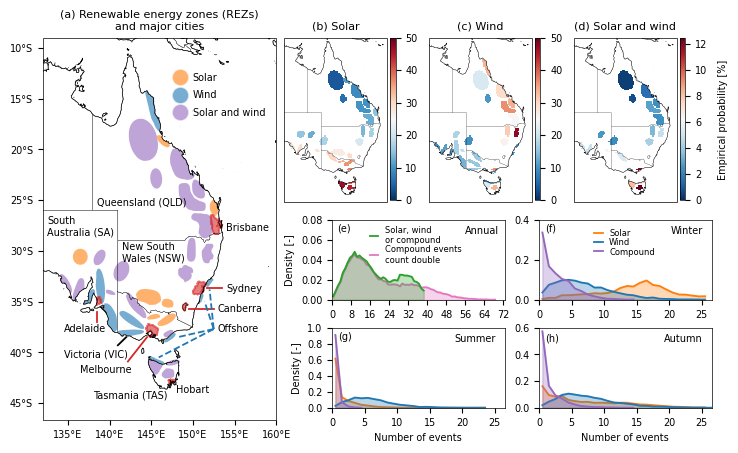

In [60]:
with plt.rc_context(plt_params):
    fig = plt.figure(dpi=100, figsize=(6.9, 4)) 
    
    # REZ and city plot
    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0, right=0.4, bottom=0, top=.955)
    ax1 = plt.subplot(gs1[0], projection=ccrs.PlateCarree())
    plot_REZ_GCCSA(ax1)
    
    # Lull probabilities
    adj = 0.05 
    gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.38, right=0.53, bottom=0.5, top=1)
    ax2 = plt.subplot(gs2[0], projection=ccrs.PlateCarree())
    plot_freq(ax2, freq_mssrd, '(b) Solar', mask=rez_mask, region_codes=[2, 3, 6, 7])
    
    gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.59, right=0.74, bottom=0.5, top=1)
    ax3 = plt.subplot(gs3[0], projection=ccrs.PlateCarree())
    plot_freq(ax3, freq_100w, '(c) Wind', mask=rez_mask, region_codes=[1, 3, 5, 7])
    
    gs4 = fig.add_gridspec(nrows=1, ncols=1, left=0.8, right=0.95, bottom=0.5, top=1)
    ax4 = plt.subplot(gs4[0], projection=ccrs.PlateCarree())
    plot_freq(ax4, freq_100w_mssrd, '(d) Solar and wind', mask=rez_mask, region_codes=[3, 7])
    
    ax4.text(1.4, 0.5, 'Empirical probability [%]', rotation=90, fontsize=plt_params['font.size'],
             transform=ax4.transAxes, va='center', ha='left')
    
    # PDFs of simultaneous events
    # Wind and solar events together, with and without double counting of compound events
    # ========================================
    gs5 = fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, bottom=0.3, top=0.5)
    ax5 = plt.subplot(gs5[0])
    hist_plot(ax5, all_events_no_compound, season_dict['Annual'],
              colors[2], 'Solar, wind\nor compound', xlim=72, zorder=1)
    hist_plot(ax5, all_events, season_dict['Annual'],
              colors[6], 'Compound events\ncount double', xlim=72, zorder=0)
    ax5.set_xticks(np.arange(0, 73, 8))
    ax5.set_ylim(0, 0.08)
    ax5.set_yticks(np.arange(0, 0.09, 0.02))
    # ax.set_xlabel('Concurrent energy lulls [number of events]')
    ax5.legend(loc=(0.2, 0.4), frameon=False)
    ax5.set_ylabel('Density [-]')
    ax5.text(56, 0.066, 'Annual')
    
    # Wind solar and compound events by season
    # ========================================
    gs_list = [
        fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=1, bottom=0.3, top=0.5),
        fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, bottom=0.03, top=0.23),
        fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=1, bottom=0.03, top=0.23),
        # fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, bottom=0., top=0.1),
        # fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=1, bottom=0., top=0.1)
    ]
    axes = [fig.add_subplot(gs[0]) for gs in gs_list]
    
    plot_seasons = season_dict.copy()
    plot_seasons.pop('Annual')
    plot_seasons.pop('Spring')
    
    for (gs, ax, months, title) in zip(gs_list, axes, plot_seasons.values(), plot_seasons.keys()):
    
        p1 = hist_plot(ax, simul_mssrd, months, colors[1], 'Solar')
        p2 = hist_plot(ax, simul_100w, months, colors[0], 'Wind')
        p3 = hist_plot(ax, simul_100w_mssrd, months, colors[4], 'Compound')
        
        ymax = np.max([p1.max(), p2.max(), p3.max()])
        ax.set_ylim(0, fn.round_decimals_up(ymax, 1))
        ax.text(0.95, 0.8, title, transform=ax.transAxes, ha='right', va='bottom')
        
        ax.set_xlim(0, 26.5)
        ax.set_xticks(np.arange(0, 27, 5))
        # ax.set_xticklabels(np.arange(0, 27, 5))
        
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc=(0.3, 0.5), frameon=False)
    
    for ax in [axes[i] for i in [1]]:
        ax.set_ylabel('Density [-]')
    for ax in [axes[i] for i in [1, 2]]:
        ax.set_xlabel('Number of events')
        
    ax5.text(2, 0.068, '(e)')
    axes[0].text(1, 0.34, '(f)')
    axes[1].text(1, 0.85, '(g)')
    axes[2].text(1, 0.5, '(h)')            
        
    plt.savefig('./figures/Fig1_statistics.pdf', format='pdf', dpi=400, bbox_inches='tight')

### Daily events on drought vs non-drought years

In [127]:
def simul_during_drought(n_droughts, thresh_n_droughts,
                         daily_events, region_codes,
                         time_name='time'):
    """
    Number of events across desired subset of regions, computed over
    all drought years and all other years (output separately).
    """
    # drought_years, other_years = fn.get_event_years(
    #     n_droughts,
    #     thresh_n_droughts,
    #     'lower'
    # )
    n_droughts = n_droughts.sel(
        region=fn.get_regions_from_region_codes([4, 5, 6, 7], rez_mask)
    ).mean('region')

    drought_years = n_droughts.where(
        n_droughts < thresh_n_droughts
    ).dropna(time_name)[time_name].dt.year.values
    
    other_years = n_droughts.where(
        n_droughts >= thresh_n_droughts
    ).dropna(time_name)[time_name].dt.year.values
    
    subset_drought = daily_events.sel({
        'region': fn.get_regions_from_region_codes(region_codes, rez_mask),
        time_name: daily_events[time_name].dt.year.isin(drought_years)
    }).sum('region')
    
    subset_other = daily_events.sel({
        'region': fn.get_regions_from_region_codes(region_codes, rez_mask),
        time_name: daily_events[time_name].dt.year.isin(other_years)
    }).sum('region')
    
    return subset_drought, subset_other

In [90]:
def ks_pval(da1, da2, months):
    """
    Return the p-value of the Kolmogorov-Smirnov test.
    """
    from scipy.stats import ks_2samp
    subset_da1 = fn.month_subset(da1, months).values
    subset_da2 = fn.month_subset(da2, months).values
    return ks_2samp(subset_da1, subset_da2)[-1]

In [91]:
def ad_pval(da1, da2, months):
    """
    Return the p-value of the Anderson-Darling test.
    """
    from scipy.stats import anderson_ksamp
    subset_da1 = fn.month_subset(da1, months).values
    subset_da2 = fn.month_subset(da2, months).values
    return anderson_ksamp([subset_da1, subset_da2])[-1]

In [92]:
def figure_dist_tests(ax, da1, da2, months):
    """
    Add the KS or AD test to a figure, if significant.
    """
    signif_tests = []
    
    ksp = ks_pval(da1, da2, months)
    if ksp < 0.05:
        signif_tests.append('KS')
        
    adp = ad_pval(da1, da2, months)
    if adp < 0.05:
        signif_tests.append('AD')
              
    ylocs = [[0.8, 0.6][i] for i in range(len(signif_tests))]
    if len(ylocs) > 0:
        for i in range(len(ylocs)):
            ax.text(0.92, ylocs[i], signif_tests[i], ha='center', transform=ax.transAxes)

In [123]:
n_simul_droughts = fn.n_simultaneous_droughts(rez_ro_ann, thresh_ro, [4, 5, 6, 7], rez_mask)

In [138]:
# Minimum number of hydro regions in drought to subset years on
# thresh_n_droughts = 3

# Or just use region-mean, 25th percentile, and then use runoff, not nDroughts
n_simul_droughts = rez_ro_ann
thresh_n_droughts = thresh_ro.values

In [139]:
simul_ro_100w_drought, simul_ro_100w_other = simul_during_drought(
    n_simul_droughts,
    thresh_n_droughts,
    events_100w, [1, 3, 5, 7]
)

In [140]:
simul_ro_mssrd_drought, simul_ro_mssrd_other = simul_during_drought(
    n_simul_droughts,
    thresh_n_droughts,
    events_mssrd, [2, 3, 6, 7]
)

In [141]:
simul_ro_100w_mssrd_drought, simul_ro_100w_mssrd_other = simul_during_drought(
    n_simul_droughts,
    thresh_n_droughts,
    events_100w_mssrd, [3, 7]
)

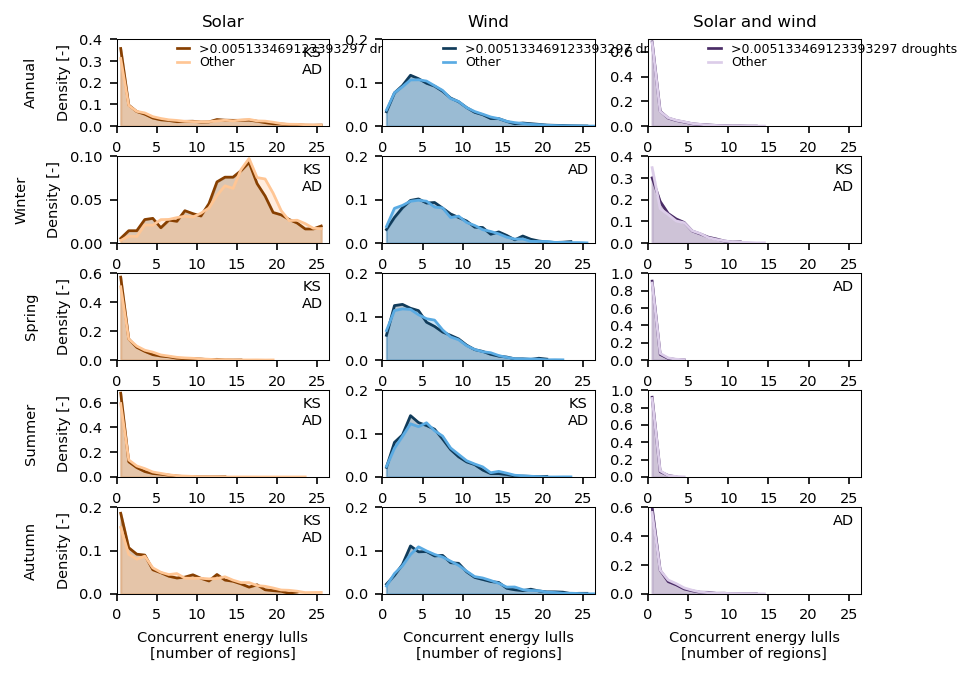

In [142]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    xlim=26
    drought_legend_label = '>'+str(thresh_n_droughts)+' droughts'

    with plt.rc_context(plt_params):
        fig = plt.figure(1, dpi=150)

        axes = []
        for i in range(15):
            axes.append(fig.add_subplot(5, 3, i+1))

        plot_colors = [colors[1], colors[0], colors[4]]

        for i, (months, title) in enumerate(zip(season_dict.values(), season_dict.keys())):

            p1 = hist_plot(axes[i*3], simul_ro_mssrd_drought, months, fn.adjust_lightness(colors[1], 0.5),
                           drought_legend_label, xlim=xlim)
            p2 = hist_plot(axes[i*3], simul_ro_mssrd_other, months, fn.adjust_lightness(colors[1], 1.5),
                           'Other', xlim=xlim)

            figure_dist_tests(axes[i*3], simul_ro_mssrd_drought, simul_ro_mssrd_other, months)

            ymax = np.max([p1.max().values, p2.max().values])
            axes[i*3].set_ylim(0, fn.round_decimals_up(ymax, 1))
            if ymax > 0.5:
                axes[i*3].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 1)+0.01, 0.2))
            elif (ymax <= 0.5) & (ymax > 0.1):
                axes[i*3].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 1)+0.01, 0.1))
            else:
                axes[i*3].set_yticks(np.arange(0, 0.11, 0.05))

            p1 = hist_plot(axes[i*3+1], simul_ro_100w_drought, months, fn.adjust_lightness(colors[0], 0.5),
                           drought_legend_label, xlim=xlim)
            p2 = hist_plot(axes[i*3+1], simul_ro_100w_other, months, fn.adjust_lightness(colors[0], 1.5),
                           'Other', xlim=xlim)

            figure_dist_tests(axes[i*3+1], simul_ro_100w_drought, simul_ro_100w_other, months)

            ymax = np.max([p1.max(), p2.max()])
            axes[i*3+1].set_ylim(0, fn.round_decimals_up(ymax, 1))
            if ymax > 0.5:
                axes[i*3+1].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 1)+0.01, 0.2))
            elif (ymax <= 0.5) & (ymax > 0.1):
                axes[i*3+1].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 1)+0.01, 0.1))
            else:
                axes[i*3+1].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 2)+0.01, 0.05))

            p1 = hist_plot(axes[i*3+2], simul_ro_100w_mssrd_drought, months, fn.adjust_lightness(colors[4], 0.5),
                           drought_legend_label, xlim=xlim)
            p2 = hist_plot(axes[i*3+2], simul_ro_100w_mssrd_other, months, fn.adjust_lightness(colors[4], 1.5),
                           'Other', xlim=xlim)

            figure_dist_tests(axes[i*3+2], simul_ro_100w_mssrd_drought, simul_ro_100w_mssrd_other, months)

            ymax = np.max([p1.max(), p2.max()])
            axes[i*3+2].set_ylim(0, fn.round_decimals_up(ymax, 1))
            if ymax > 0.5:
                axes[i*3+2].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 1)+0.01, 0.2))
            elif (ymax <= 0.5) & (ymax > 0.1):
                axes[i*3+2].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 1)+0.01, 0.1))
            else:
                axes[i*3+2].set_yticks(np.arange(0, fn.round_decimals_up(ymax, 2)+0.001, 0.05))

        for ax in axes[:3]:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, loc=(0.26, 0.6), frameon=False)

        for ax, title in zip([axes[i] for i in [0, 3, 6, 9, 12]], season_dict.keys()):
            ax.set_ylabel(title+'\n\nDensity [-]')
        for ax in axes[-3:]:
            ax.set_xlabel('Concurrent energy lulls\n[number of regions]')

        axes[0].set_title('Solar')
        axes[1].set_title('Wind')
        axes[2].set_title('Solar and wind')
        
        plt.subplots_adjust(hspace=0.35, wspace=0.25)

### Note on plot:
The PDFs look similar on drought versus non-drought years. KS and AD tests often imply there's enough evidence to reject the hypothesis that the distributions are the same. This suggests we have statistical significance that they are different, although maybe there is no *practical* significance.

# Which regions tend to have simultaneous lulls?

How can we show this?

1. Count number of lulls in each region that coincide with lulls in one selected region. So subsample lulls on that one region's lulls. then repeat for a geographically distinct region.
2. Some kind of network graph that shows probabilities between each region? Might be very messy when plotted on a map. Could do regions in column format with those bands that come off and attach to regions on the right hand side?

In [38]:
region = 'N1'

In [40]:
events_100w.where(events_100w.sel(region=region) == 1).sum('time') # number of wind lulls that coincide with wind lulls in N1

<xarray.DataArray '100w' (region: 39)>
array([7091., 5854., 4385., 1097., 2030., 3285., 5349., 4853., 1295.,
       1100.,  942.,  513., 1835., 1388., 3458., 2235., 1003., 3042.,
       3170., 3606., 3859., 1110., 1636., 1452.,  901., 1867., 1724.,
       1038.,  908.,  709., 1258., 1406., 2250., 5437., 1571., 1314.,
       1275., 2846., 2300.])
Coordinates:
  * region    (region) <U2 'N1' 'N2' 'N3' 'N4' 'N5' ... 'V2' 'V3' 'V4' 'V5' 'V6'
    quantile  float64 0.25

### note: I've paused this analysis as might be better suited to wind power/solar power etc, rather than climate variables.

This is because these figure ideas feel quite operational. Might be better to stick to the climate side for now. See Word doc.

# Seasonal summaries

In [148]:
def plot_seasonal_ts(da1, da2, da3, hydro_da, roll, alpha, second_roll=None, drought_or_runoff='Drought'):
    """
    Plot seasonal time series.
    """
    if drought_or_runoff == 'Drought':
        hydro_da = hydro_da.resample(time='1Y').mean()
        ylabel = r'Droughts [events year$^{-1}$]'
    elif drought_or_runoff == 'Runoff':
        hydro_da = hydro_da.rolling(time=roll).mean() * 1000
        ylabel = r'REZ-averaged runoff [mm day$^{-1}$]'
    else:
        raise ValueError("Incorrect drought_or_runoff.")
    
    with plt.rc_context(plt_params):
        fig, ax = plt.subplots(1, 1, figsize=(6.9, 2))
        
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        
        da1.rolling(time=roll).mean().plot(ax=ax, color=colors[0], alpha=alpha, zorder=0, label='Wind')
        da2.rolling(time=roll).mean().plot(ax=ax, color=colors[1], alpha=alpha, zorder=0, label='Solar')
        da3.rolling(time=roll).mean().plot(ax=ax2, color=colors[4], alpha=alpha, zorder=0, label='Compound')
        hydro_da.plot(ax=ax3, color='k', alpha=alpha, zorder=0, label=drought_or_runoff)
        
        if second_roll is not None:
            da1.rolling(time=second_roll).mean().plot(ax=ax, color=colors[0], zorder=1)
            da2.rolling(time=second_roll).mean().plot(ax=ax, color=colors[1], zorder=1)
            da3.rolling(time=second_roll).mean().plot(ax=ax2, color=colors[4], zorder=1)
            hydro_da.rolling(time=second_roll//12).mean().plot(ax=ax3, color='k', zorder=0)
            title = str(roll)+'- and '+str(second_roll)+'-season rolling mean'
        else:
            title = str(roll)+'-season rolling mean'
            
        ax.set_title(title)
        ax.set_ylabel(r'Solar/wind lulls [events day$^{-1}$]')
        
        ax2.set_title('')
        ax2.set_ylabel(r'Compound lulls [events day$^{-1}$]')
        
        ax3.set_title('')
        ax3.spines['right'].set_position(("axes", 1.13))
        ax3.set_ylabel(ylabel)
        
        ax.legend(frameon=False, loc=(0.01, 0.83))
        ax2.legend(frameon=False, loc=(0.1, 0.895))
        ax3.legend(frameon=False, loc=(0.1, 0.83))

In [144]:
season_100w = fn.seasonal_mean(simul_100w)
season_mssrd = fn.seasonal_mean(simul_mssrd)
season_100w_mssrd = fn.seasonal_mean(simul_100w_mssrd)

In [145]:
season_ro = fn.seasonal_mean(
    rez_ro.sel(
        region=fn.get_regions_from_region_codes([4, 5, 6, 7], rez_mask)
    ).mean('region')
)

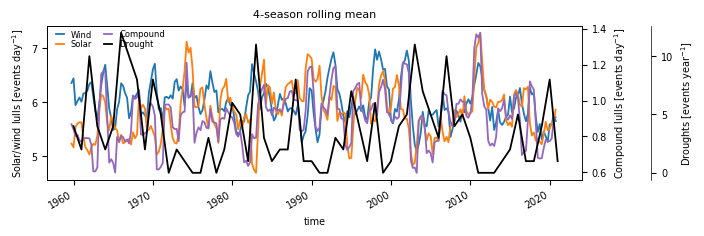

In [91]:
plot_seasonal_ts(season_100w, season_mssrd, season_100w_mssrd, season_ro, 4, 1)

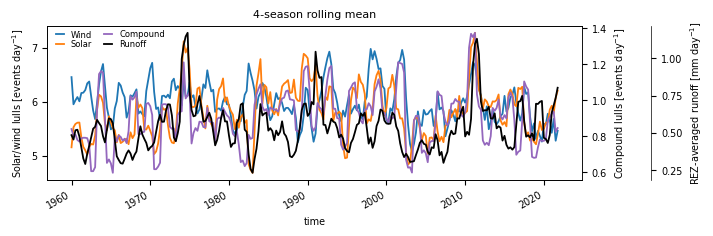

In [151]:
plot_seasonal_ts(season_100w, season_mssrd, season_100w_mssrd, season_ro, 4, 1, drought_or_runoff='Runoff')

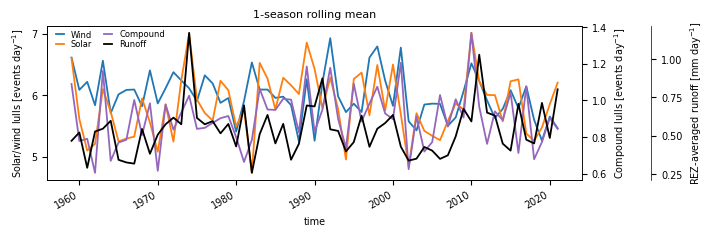

In [152]:
plot_seasonal_ts(season_100w.resample(time='1YS').mean(),
                 season_mssrd.resample(time='1YS').mean(),
                 season_100w_mssrd.resample(time='1YS').mean(),
                 season_ro.resample(time='1YS').mean(),
                 1, 1, drought_or_runoff='Runoff')

### Seasonal summaries of gridded events

In [48]:
def seasonal_sum(da, time_name='time'):
    """
    Calculate seasonal sums. Currently assumes da starts in January.
    First aggregates to monthly, then shifts everything forwards
    one month, then aggregates over 3 months.
    """
    first_month = da[time_name].dt.month.values[0]
    if first_month != 1:
        raise ValueError("First month should be January. Adjust da or function.")
        
    # First aggregate to monthly as we want to shift a month ahead
    m_da = da.resample({time_name: '1MS'}).sum()
    # Now shift a month ahead and calculate 3-monthly means
    return m_da.shift({time_name: 1}).resample({time_name: '3MS'}).sum(skipna=False)

First get gridded events

In [49]:
aus_events_mssrd = fn.get_events(aus_mssrd, thresh_mssrd, tail='lower')
aus_events_100w = fn.get_events(aus_100w, thresh_100w, tail='lower')
aus_events_100w_mssrd = fn.get_compound_events(aus_100w, aus_mssrd, thresh_100w, thresh_mssrd)

Now get the seasonal totals

In [50]:
aus_events_mssrd_seasonal = seasonal_sum(aus_events_mssrd).compute()
aus_events_100w_seasonal = seasonal_sum(aus_events_100w).compute()
aus_events_both_seasonal = seasonal_sum(aus_events_100w_mssrd).compute()

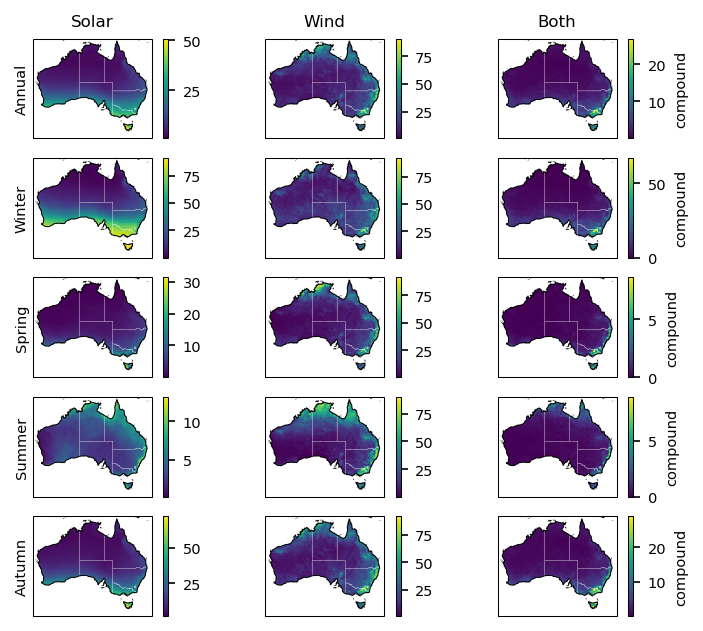

In [53]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    with plt.rc_context(plt_params):
        fig, axes = plt.subplots(5, 3, figsize=(6., 5), dpi=150, subplot_kw={'projection': ccrs.PlateCarree()})

        for ax in axes.flatten():
            ax.set_extent([112, 155, -10, -44])
            ax.add_feature(
                cartopy.feature.NaturalEarthFeature(
                    category='cultural',
                    name='admin_1_states_provinces',
                    scale='10m'
                ),
                facecolor='none',
                edgecolor='white',
                lw=.1
            )
            ax.add_feature(
                cartopy.feature.OCEAN, facecolor='white', zorder=2
            )
            ax.coastlines()

        for i, season in enumerate(list(season_dict.keys())[:]):
            for j, (name, event_da) in enumerate(zip(
                ['Solar', 'Wind', 'Both'],
                [aus_events_mssrd_seasonal, aus_events_100w_seasonal, aus_events_both_seasonal]
            )):
                da = fn.month_subset(event_da, season_dict[season])

                da.mean('time').plot(ax=axes[i,j])

                # da.std('time').plot.contour(ax=axes[i,j], colors='k', levels=np.arange(0, 30, 5), linewidths=1)
                # da.std('time').plot.contour(ax=axes[i,j], colors='white', levels=np.arange(0, 30, 5), linewidths=0.5)

                if i == 0:
                    axes[i,j].set_title(name)
                else:
                    axes[i,j].set_title('')

                if j == 0:
                    axes[i,j].text(-0.15, 0.5, season, va='center', rotation=90, transform=axes[i,j].transAxes)
                    
        plt.subplots_adjust(wspace=0.0)

# Close cluster

In [54]:
client.close()
cluster.close()